Thanks to this article https://medium.com/analytics-vidhya/primer-on-gps-data-with-strava-and-python-cd7c6c1d715a and https://towardsdatascience.com/parsing-fitness-tracker-data-with-python-a59e7dc17418/

Uses this library https://pypi.org/project/gpxpy/

In [120]:
import gpxpy

#path = 'Strava/L_Etape_2022.gpx'
#path = '../Strava/L_Etape_2024.gpx'
#path = '../Strava/L_Etape_2023.gpx'
path = 'Strava/Ronde_Van_Vlaanderen_2022.gpx'

with open(path, 'r') as f:
   gpx = gpxpy.parse(f)

print('Tracks ',len(gpx.tracks))
print(gpx.tracks[0].name)
print('Segments ', len(gpx.tracks[0].segments))
print('Segment Points ', len(gpx.tracks[0].segments[0].points))

data = gpx.tracks[0].segments[0].points

track = gpx.tracks[0]
segment = track.segments[0]
random_point = segment.points[11144]
point = random_point
last_point = segment.points[11143]
random_point

Tracks  1
Ronde Van Vlaanderen 2022
Segments  1
Segment Points  34843


GPXTrackPoint(50.885137, 3.89582, elevation=59.0, time=datetime.datetime(2022, 4, 2, 8, 18, 27, tzinfo=SimpleTZ('Z')))

In [121]:
import mpu

power = None
hr = None
cadence = None
temp = None
# Safely access extensions
for ext in point.extensions:
    if ext.tag.endswith('power'):
        power = ext.text
    if ext is not None:
        for child in ext:
            if (child.tag.endswith('hr')):
                hr = child.text
            if (child.tag.endswith('cad')):
                cadence = child.text
            if (child.tag.endswith('atemp')):
                temp = child.text
duration = point.time - last_point.time
dist = mpu.haversine_distance((point.latitude, point.longitude), (last_point.latitude, last_point.longitude))
print(dist)  # gives 278.45817507541943.
print(duration)
print(point.latitude)
print(power)
print(cadence)
print(hr)

0.006013357686656416
0:00:01
50.885137
234
66
159


In [122]:
import pandas as pd

df = pd.DataFrame(columns=['lat', 'lon', 'ele','time','power', 'hr', 'cad','temperature'
# don't add empty columns                           ,'distance','alt_difference', 'duration'
                           ])
last_point = None
for point in data:
    power = None
    hr = None
    cadence = None
    temp = None
    # Safely access extensions
    for ext in point.extensions:
        if ext.tag.endswith('power'):
            power = int(ext.text)
        if ext is not None:
            for child in ext:
                if (child.tag.endswith('hr')):
                    hr = int(child.text)
                if (child.tag.endswith('cad')):
                    cadence = int(child.text)
                if (child.tag.endswith('atemp')):
                    temp = float(child.text)
    new_row = pd.DataFrame({'lat': [point.latitude],
                            'lon': [point.longitude],
                            'ele': [point.elevation],
                            'time': [point.time],
                            'power': [power]
                            ,'hr': [hr],
                            'cad': [cadence]
                            ,'temperature': [temp]
                            })
    df = pd.concat([df, new_row], ignore_index=True)



/var/folders/16/bplm70c55mj7020_2tms62sh0000gn/T/ipykernel_48055/1551890944.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


In [123]:
df['hr'] = df['hr'].astype(int)
df['cad'] = df['cad'].astype(int)
df['power'] = df['power'].astype(float)
df['temperature'] = df['temperature'].astype(float)

Gradient will affect cadence, especially on long or steep climbs.

New riders will tend to not use gears to overcome gradient and tend to power through, and I know when I'm fatigued, I do this.

In [124]:
import numpy as np
import geopy.distance

df['distance'] = pd.Series(dtype='float')
df['alt_difference'] = pd.Series(dtype='float')
df['duration'] = pd.Series(dtype='float')
df['velocity'] = pd.Series(dtype='float')

for i in range(1, len(df)):
    coords_1 = (df.loc[i-1, 'lat'],df.loc[i-1, 'lon'])
    coords_2 = (df.loc[i, 'lat'],df.loc[i, 'lon'])
    distance = geopy.distance.geodesic(coords_1, coords_2).m
    elevation =  df.loc[i, 'ele'] - df.loc[i-1, 'ele']
    duration = (df.loc[i, 'time'] - df.loc[i-1, 'time']).total_seconds()
    # filter out odd gps coords
    if distance > 30 or distance == 0:
        distance = None
        elevation = None
        duration = None
    if distance is not None and elevation is not None:
        velocity = 3.6 * np.sqrt(distance**2 + elevation**2)
    else:
        velocity = None
    df.loc[i, 'distance'] = distance
    df.loc[i, 'alt_difference'] = elevation
    df.loc[i, 'velocity'] = velocity
    df.loc[i, 'duration'] = duration

Probably need to add some labels here:

- Heart Rate Zone
- Power zone

Suspect the big label for me is gradient, and I'm probably not that well-rounded in my training.

In [125]:
df

,lat,lon,ele,time,power,hr,cad,temperature,distance,alt_difference,duration,velocity
0,51.218620,4.396423,16.6,2022-04-02 05:00:17+00:00,NaN,114,0,6.0,NaN,NaN,NaN,NaN
1,51.218620,4.396423,16.6,2022-04-02 05:00:18+00:00,0.0,115,0,6.0,NaN,NaN,NaN,NaN
2,51.218623,4.396424,16.4,2022-04-02 05:00:19+00:00,0.0,115,0,6.0,0.340992,-0.2,1.0,1.423141
3,51.218670,4.396435,16.4,2022-04-02 05:00:20+00:00,0.0,116,0,6.0,5.285044,0.0,1.0,19.026158
4,51.218674,4.396438,16.4,2022-04-02 05:00:21+00:00,0.0,116,0,6.0,0.491901,0.0,1.0,1.770844
...,...,...,...,...,...,...,...,...,...,...,...,...
34838,50.843300,3.604234,10.0,2022-04-02 16:10:02+00:00,0.0,122,0,6.0,0.893466,0.2,1.0,3.296076
34839,50.843304,3.604235,10.0,2022-04-02 16:10:03+00:00,0.0,122,0,6.0,0.450521,0.0,1.0,1.621875
34840,50.843307,3.604235,10.2,2022-04-02 16:10:04+00:00,0.0,122,0,6.0,0.333736,0.2,1.0,1.400671
34841,50.843308,3.604235,10.2,2022-04-02 16:10:05+00:00,0.0,121,0,6.0,0.111245,0.0,1.0,0.400483


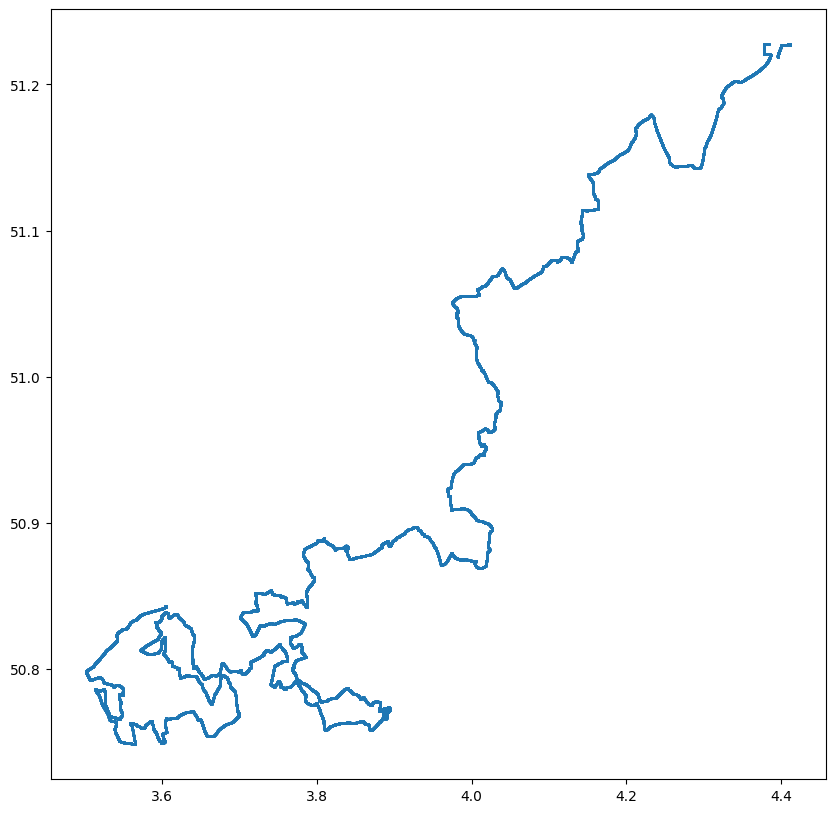

In [126]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.plot(df.lon, df.lat, 'o', markersize=1)

time column with time zone causes issues with plotting functions.
Turn the time column into an index

In [127]:
df['time'] = df['time'].dt.tz_localize(None)
df = df.set_index('time')
df.head()

,lat,lon,ele,power,hr,cad,temperature,distance,alt_difference,duration,velocity
time,,,,,,,,,,,
2022-04-02 05:00:17,51.218620,4.396423,16.6,NaN,114,0,6.0,NaN,NaN,NaN,NaN
2022-04-02 05:00:18,51.218620,4.396423,16.6,0.0,115,0,6.0,NaN,NaN,NaN,NaN
2022-04-02 05:00:19,51.218623,4.396424,16.4,0.0,115,0,6.0,0.340992,-0.2,1.0,1.423141
2022-04-02 05:00:20,51.218670,4.396435,16.4,0.0,116,0,6.0,5.285044,0.0,1.0,19.026158
2022-04-02 05:00:21,51.218674,4.396438,16.4,0.0,116,0,6.0,0.491901,0.0,1.0,1.770844


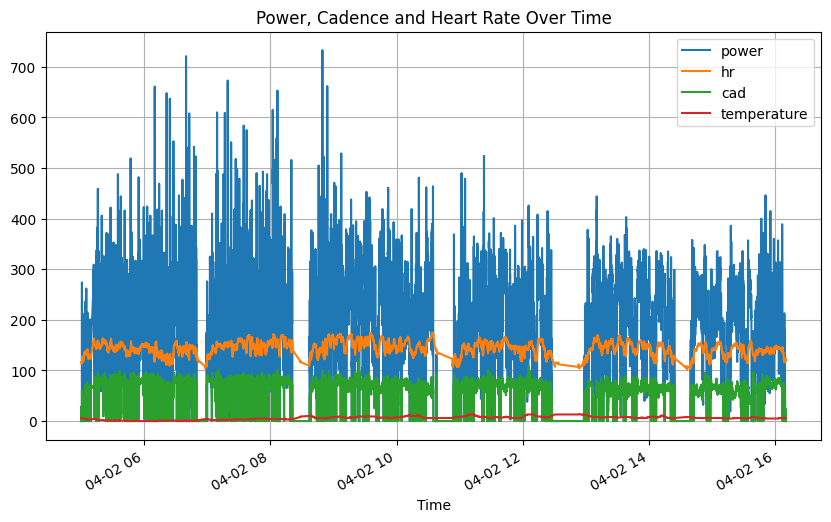

In [128]:
close_px = df[['power','hr','cad','temperature']]
close_px.plot(kind='line',
              figsize=(10, 6),
              title='Power, Cadence and Heart Rate Over Time',
              grid=True,
              legend=True)
plt.xlabel('Time')
plt.show()


/var/folders/16/bplm70c55mj7020_2tms62sh0000gn/T/ipykernel_48055/149609467.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  move_px['gradient'] = move_px['alt_difference'].mul(100).div(move_px['distance'].replace(0, np.nan))


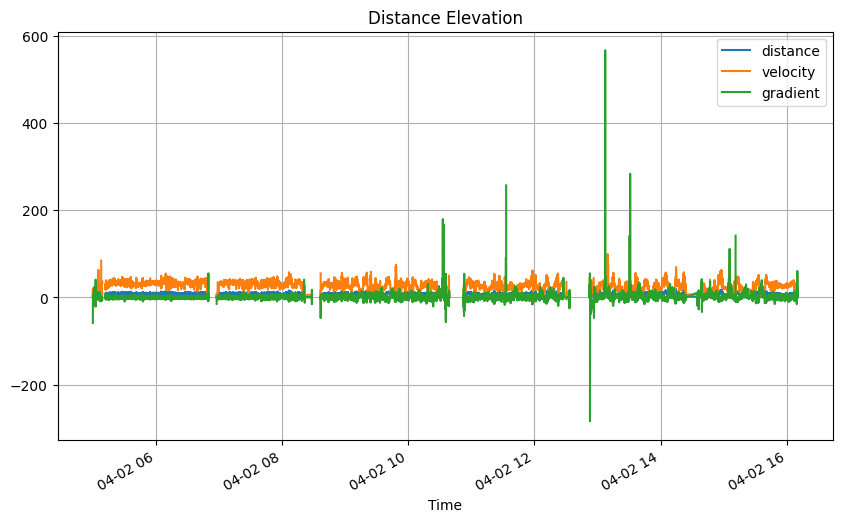

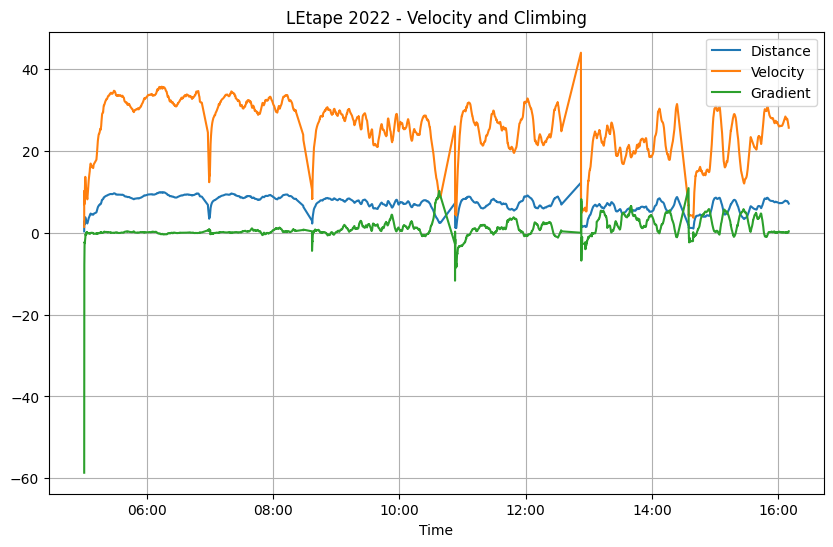

In [129]:
import matplotlib.dates as mdates


move_px = df[['distance','alt_difference','velocity']]

move_px['gradient'] = move_px['alt_difference'].mul(100).div(move_px['distance'].replace(0, np.nan))

move_px = move_px.drop(columns=['alt_difference'])

move_px.plot(kind='line',
              figsize=(10, 6),
              title='Distance Elevation',
              grid=True,
              legend=True)
plt.xlabel('Time')
plt.show()

rolling_mean = move_px.rolling('600s').mean()

plt.figure(figsize=(10, 6))
plt.plot(rolling_mean.index, rolling_mean)
plt.xlabel('Time')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().legend(['Distance', 'Velocity', 'Gradient'])
plt.title('L''Etape 2022 - Velocity and Climbing')
plt.grid(True)
plt.show()

In [130]:
move_px

,distance,velocity,gradient
time,,,
2022-04-02 05:00:17,NaN,NaN,NaN
2022-04-02 05:00:18,NaN,NaN,NaN
2022-04-02 05:00:19,0.340992,1.423141,-58.652433
2022-04-02 05:00:20,5.285044,19.026158,0.000000
2022-04-02 05:00:21,0.491901,1.770844,0.000000
...,...,...,...
2022-04-02 16:10:02,0.893466,3.296076,22.384747
2022-04-02 16:10:03,0.450521,1.621875,0.000000
2022-04-02 16:10:04,0.333736,1.400671,59.927639


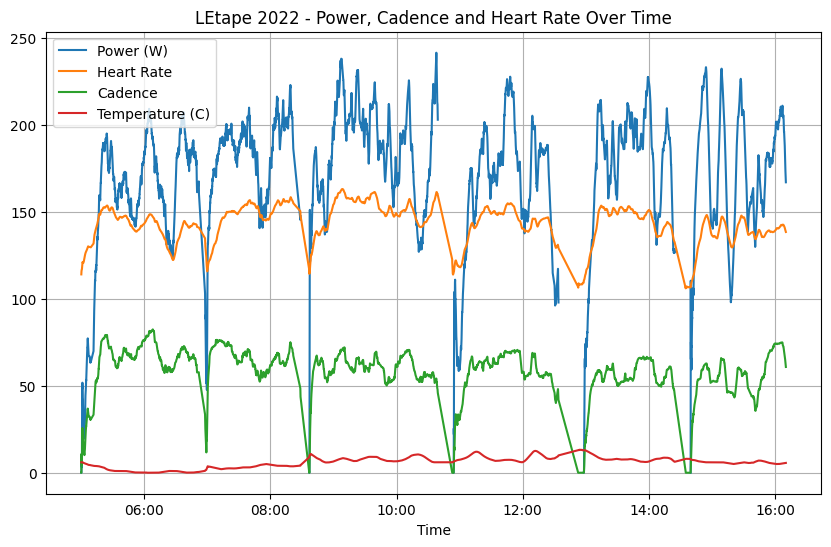

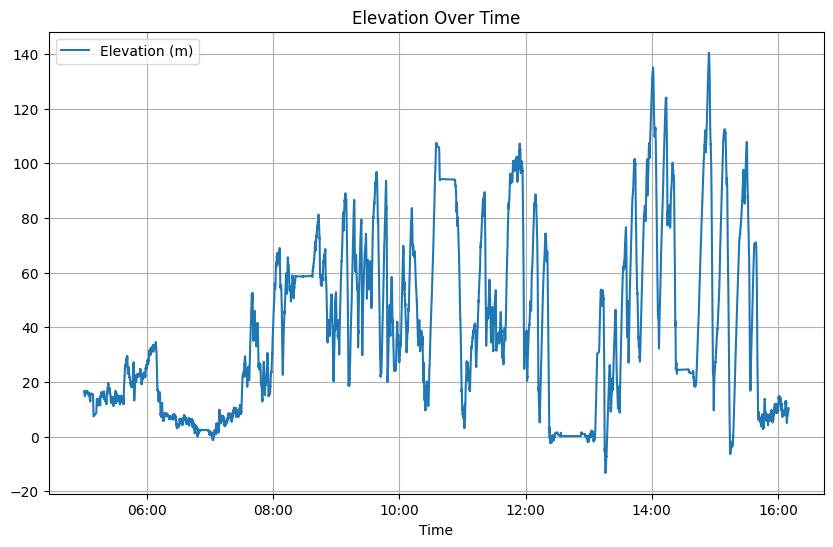

In [131]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

rolling_mean = close_px.rolling('600s').mean()

plt.figure(figsize=(10, 6))
plt.plot(rolling_mean.index, rolling_mean)
plt.xlabel('Time')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().legend(['Power (W)', 'Heart Rate', 'Cadence', 'Temperature (C)'])
plt.title('L''Etape 2022 - Power, Cadence and Heart Rate Over Time')
plt.grid(True)
plt.show()

elevation = df[['ele']]
plt.figure(figsize=(10, 6))
plt.plot(elevation.index, elevation)
plt.xlabel('Time')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().legend(['Elevation (m)'])
plt.title('Elevation Over Time')
plt.grid(True)
plt.show()

Calculate values for [Physical Activity - Activity-based Measures](https://build.fhir.org/ig/HL7/physical-activity/measures.html#activity-based-measures)

Convert to FHIR Bundle (type = collection)

In [132]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression


df['gradient'] = df['alt_difference'].mul(100).div(df['distance'].replace(0, np.nan))

strava = df[['power','hr','cad','temperature'
    ,'distance'
    ,'gradient'
   # ,'velocity'
             ]].dropna()

stravaT = strava[['hr','cad','temperature'
    ,'power'
    ,'gradient'
  #  ,'velocity'
                  ]]
X = pd.DataFrame(scale(stravaT))
y = strava.distance

print(f"Shape of X: {X.shape}")  # Check original shapes
print(f"Shape of y: {y.shape}")


X_Train, X_Test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state = 4200)

lm = LinearRegression()
lm.fit(X_Train,y_train)

Shape of X: (34404, 5)
Shape of y: (34404,)


LinearRegression()

In [133]:
print(f"R2 : {lm.score(X_Train, y_train):0.3}")

R2 : 0.405


In [134]:
for coef, column in zip(lm.coef_, stravaT.columns):
    print(f"{column}: {round(coef, 1)}")

stravaT.mean()



hr: -0.4
cad: 0.7
temperature: -0.7
power: -0.8
gradient: -1.0


hr             145.078101
cad             60.933496
temperature      5.747646
power          175.626642
gradient         1.209153
dtype: float64

In [135]:
stravaT.std()

hr              12.560023
cad             25.981194
temperature      3.156284
power          103.695185
gradient         6.548707
dtype: float64

In [136]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_Train,y_train >= 1)

from sklearn.metrics import accuracy_score

in_sample_acc = accuracy_score(y_train>=35, lr.predict(X_Train))
out_sample_acc = accuracy_score(y_test>=35, lr.predict(X_Test))

print(f'In sample accurary {in_sample_acc:0.3}')
print(f'Out sample accurary {out_sample_acc:0.3}')

In sample accurary 0.000545
Out sample accurary 0.00102


In [137]:
for var, coef,strat in zip(X_Train.columns, lr.coef_[0],stravaT.columns):
    print(f'{strat:11} {var:7} : {coef:0.3}')

hr                0 : 0.0579
cad               1 : 1.85
temperature       2 : -0.314
power             3 : -0.00083
gradient          4 : -0.907


In [144]:
print(lr.classes_)

print('\nProbablities\n',lr.predict_proba(X_Test)[:10,:])

[False  True]

Probablities
 [[1.39546735e-02 9.86045326e-01]
 [1.56101490e-02 9.84389851e-01]
 [2.52608330e-04 9.99747392e-01]
 [4.87755417e-05 9.99951224e-01]
 [7.21538530e-05 9.99927846e-01]
 [1.79522000e-02 9.82047800e-01]
 [1.06114776e-04 9.99893885e-01]
 [4.20069619e-05 9.99957993e-01]
 [6.44405199e-04 9.99355595e-01]
 [1.67317926e-04 9.99832682e-01]]
